In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [6]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [8]:
train_data = datasets.MNIST('./mnist', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./mnist', download=True, train=False, transform=transform)

|          | 0/? [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [11]:
img, labels = next(iter(train_loader))

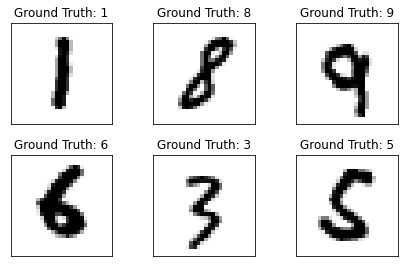

In [12]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(img[i][0], cmap='binary')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, (5,5), 1)
        self.c2 = nn.Conv2d(32, 32, (5,5), 1)
        self.c3 = nn.Conv2d(32, 64, (3,3), 1)
        self.c4 = nn.Conv2d(64, 64, (3,3), 1)
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d((2,2))
        self.max_pool2 = nn.MaxPool2d((2,2), (2,2))
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.relu(self.c2(x))
        x = self.dropout1(self.max_pool1(x))
        x = self.relu(self.c3(x))
        x = self.relu(self.c4(x))
        x = self.dropout1(self.max_pool2(x))
        x = self.dropout2(self.relu(self.fc1(x.view(x.size(0), -1))))
        x = self.fc2(x)
        
        return x

In [15]:
model = Net()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
EPOCHS = 5

for epoch in range(EPOCHS):
    running_loss = 0
    
    for i, (img, labels) in enumerate(train_loader):
        img = img.view(-1,1,28,28)
        img = img.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch:{epoch+1}, loss:{running_loss/len(train_loader)}")

Epoch:1, loss:0.285945041255715
Epoch:2, loss:0.08811246933570753
Epoch:3, loss:0.0625312940737543
Epoch:4, loss:0.05368551090708934
Epoch:5, loss:0.043860696226668855


In [17]:
from sklearn.metrics import accuracy_score

acc = 0
for batch_idx, (img, labels) in enumerate(train_loader):
    img = img.to(device)
    pred = torch.argmax(model(img), axis=1).cpu()
    acc_score = accuracy_score(labels, pred)
    acc += acc_score
    
print("The avg acc in training set is %f"%(acc/len(train_loader)))

The avg acc in training set is 0.987067


In [19]:
torch.save(model.state_dict(),'./model/mnist_model5.pt')